# Setup

In [1]:
import torch
import numpy as np

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

from IPython.display import clear_output

# Defining, training, and plotting features of a toy model

In [2]:
from sae_lens.training.toy_models import ToyConfig, ReluOutputModel

cfg = ToyConfig(
    n_instances=1,
    n_features=5,
    n_hidden = 2,
    feature_probability = 0.1,
    device=device
)
model = ReluOutputModel(cfg)
model.optimize()

Training Toy Model: 100%|██████████| 10000/10000 [00:02<00:00, 4004.01it/s, loss=0.00596, lr=0.001]


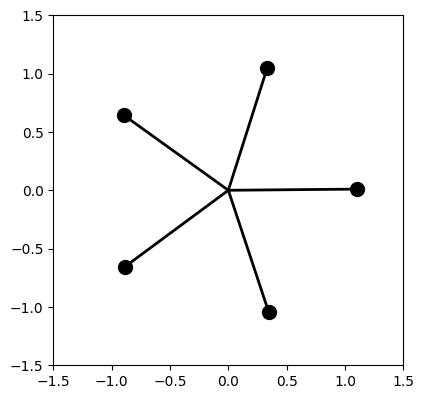

In [3]:
from sae_lens.training.toy_models import plot_features_in_2d

plot_features_in_2d(values=model.W)

In [4]:
# note that the model is built on HookedRootModule, so can be run_with_cache.
batch = model.generate_batch(10)
output, cache = model.run_with_cache(batch)
print(cache.keys())

dict_keys(['hook_hidden', 'hook_out_prebias'])


# Make an activation store for toy models

# Training an SAE on the toy model

In [10]:
from sae_lens.training.config import LanguageModelSAERunnerConfig
from sae_lens.training.sae_group import SparseAutoencoderDictionary
from sae_lens.training.activations_store import ToyActivationsStore

sae_cfg = LanguageModelSAERunnerConfig(
    model_name="5-in-2-toy",
    hook_point='hook_hidden',
    hook_point_eval='hook_hidden',
    dtype = torch.float32,
    cached_activations_path=None,
    d_in=cfg.n_hidden,
    log_to_wandb=False,
    context_size=1,
    store_batch_size = 1024,
    train_batch_size = 1024, #too large (4096) seems detrimental
    n_batches_in_buffer= 100000,
    training_tokens=16_000_000,
    l1_coefficient=0.1,
    lr=1e-3,
    expansion_factor=3,
    use_ghost_grads=True,
    dead_feature_window=2000,
)
# sae_cfg.expansion_factor = 2.5
# sae_cfg.d_sae = 5

store = ToyActivationsStore.from_config(model, sae_cfg)
# sae = SparseAutoencoder(sae_cfg)
# sae = train_sae_on_language_model(sae, model, store)#, n_epochs=1000)

sae_group = SparseAutoencoderDictionary(sae_cfg)


clear_output()

In [12]:
from sae_lens.training.train_sae_on_language_model import train_sae_group_on_language_model

train_sae_group_on_language_model(model, sae_group, store,
        n_checkpoints=sae_cfg.n_checkpoints,
        batch_size=sae_cfg.train_batch_size,
        feature_sampling_window=sae_cfg.feature_sampling_window,
        use_wandb=sae_cfg.log_to_wandb,
        wandb_log_frequency=sae_cfg.wandb_log_frequency,)

Objective value: 12297926.0000:   2%|▏         | 2/100 [00:01<01:25,  1.14it/s]
/Users/evananders/research/code/SAELens/sae_lens/training/sparse_autoencoder.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(origin, dtype=self.dtype, device=self.device)
15625| MSE Loss 0.006 | L1 0.019: 100%|██████████| 16000000/16000000 [01:16<00:00, 208592.25it/s]


TrainSAEGroupOutput(sae_group=<sae_lens.training.sae_group.SparseAutoencoderDictionary object at 0x3e7393ec0>, checkpoint_paths=['checkpoints/cfem8pzp/final'], log_feature_sparsities={'5-in-2-toy_hook_hidden_6_': tensor([-0.8894, -0.8852, -0.8874, -6.2213, -0.8874, -0.8880])})

5-in-2-toy_hook_hidden_6_ SparseAutoencoder(
  (activation_fn): ReLU()
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)


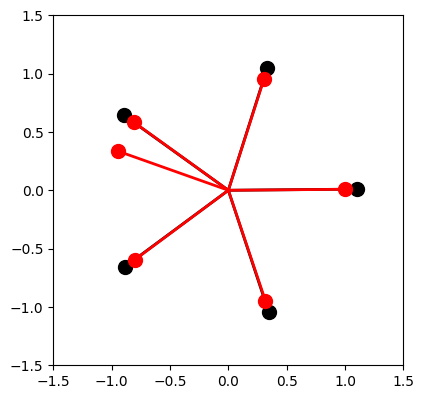

In [14]:
for name, sae in sae_group.autoencoders.items():
    print(name, sae)
    vecs = torch.cat((model.W, sae.W_dec.T[None,:]), dim=-1)
    plot_features_in_2d(values=vecs, colors=['k']*cfg.n_features+['r']*sae.cfg.d_sae)

In [15]:
from sae_lens.training.evals import run_evals

for name, sae in sae_group.autoencoders.items():
    evals = run_evals(sae, store, model, n_training_steps=0)
    print(name, evals)

5-in-2-toy_hook_hidden_6_ {'metrics/l2_norm': 0.1752324104309082, 'metrics/l2_ratio': 0.23241844773292542, 'metrics/loss_score': 0.8619741678237915, 'metrics/loss_without_sae': 0.005164263769984245, 'metrics/loss_with_sae': 0.009179404191672801, 'metrics/loss_with_ablation': 0.03439241051673889}


# Simple lm runner

In [16]:
from sae_lens.training.lm_runner import toy_model_sae_runner

model, sae_group = toy_model_sae_runner(sae_cfg, cfg)

Training Toy Model: 100%|██████████| 10000/10000 [00:02<00:00, 3443.97it/s, loss=0.00479, lr=0.001]


Run name: 6-L1-0.1-LR-0.001-Tokens-1.600e+07
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training steps: 15625
Total wandb updates: 1562
n_tokens_per_feature_sampling_window (millions): 2.048
n_tokens_per_dead_feature_window (millions): 2.048
We will reset the sparsity calculation 7 times.
Number tokens in sparsity calculation window: 2.05e+06
Using Ghost Grads.
Run name: 6-L1-0.1-LR-0.001-Tokens-1.600e+07
n_tokens_per_buffer (millions): 102.4
Lower bound: n_contexts_per_buffer (millions): 102.4
Total training steps: 15625
Total wandb updates: 1562
n_tokens_per_feature_sampling_window (millions): 2.048
n_tokens_per_dead_feature_window (millions): 2.048
We will reset the sparsity calculation 7 times.
Number tokens in sparsity calculation window: 2.05e+06
Using Ghost Grads.


Objective value: 12281451.0000:   2%|▏         | 2/100 [00:01<01:29,  1.09it/s]
15625| MSE Loss 0.005 | L1 0.020: 100%|██████████| 16000000/16000000 [01:13<00:00, 217427.08it/s]


['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_init_autoencoders', 'autoencoders', 'cfg', 'eval', 'get_name', 'load_from_pretrained', 'load_from_pretrained_legacy', 'save_saes', 'to', 'train']
5-in-2-toy_hook_hidden_6_ SparseAutoencoder(
  (activation_fn): ReLU()
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)


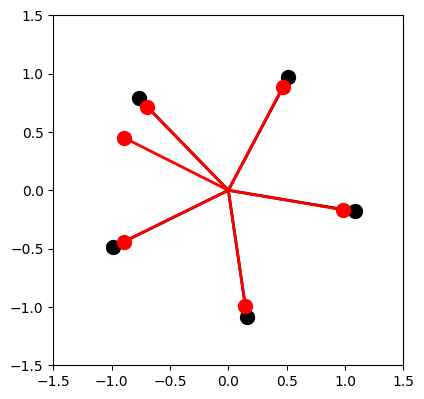

In [17]:
print(dir(sae_group))
for name, sae in sae_group.autoencoders.items():
    print(name, sae)
    vecs = torch.cat((model.W, sae.W_dec.T[None,:]), dim=-1)
    plot_features_in_2d(values=vecs, colors=['k']*cfg.n_features+['r']*sae.cfg.d_sae)